# Example notebook for making spatial averages of observational products
This notebook uses two different observational products, OISST and ERA5, and demonstrates:
1. Reordering latitude
2. Calculating grid areas
3. Nice maps with cartopy
4. Extracting regional subsets
5. Taking area-weighted means
6. Calculating monthly climatologies and anomalies

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import numpy as np

In [3]:
from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds

## Set observational paths

In [4]:
# SST
sst_dir = '/work/Marion.Alberty/data/OISST_pp/'
# Winds
v10_dir = '/work/Marion.Alberty/data/ERA5_pp/v_10m/'
# ERA5 land mask
e5lm_dir = '/uda/ERA5/Monthly_Averaged_Data_On_Single_Levels/reanalysis/global/annual_file-range/Other/land-sea_mask/'

## Get file lists

In [5]:
# SST
flist_sst = glob(f'{sst_dir}NCEI_OISST_monthly_SST_*.nc')
# Winds
flist_v10 = glob(f'{v10_dir}ERA5_monthly_v_10m_*.nc')
# ERA 5 land-sea mask
flist_e5lm = f'{e5lm_dir}ERA5_monthly_averaged_land_sea_mask_2021.nc'

## Read in observational data

In [6]:
def fix_latlon(ds):
    # Rename to lat, lon
    ds = ds.rename({'longitude':'lon','latitude':'lat'})
    # reindex for increasing lat
    ds = ds.reindex(lat=list(reversed(ds.lat)))
    return ds

In [7]:
# SST
DS_sst = xr.open_mfdataset(flist_sst,engine='netcdf4')

In [8]:
# Winds
DS_v10 = fix_latlon(xr.open_mfdataset(flist_v10,engine='netcdf4'))

In [9]:
# ERA5 land mask
DS_e5lm = fix_latlon(xr.open_dataset(flist_e5lm,engine='netcdf4')).isel(time=0).drop_vars('time')

## Make grid objects and add metrics

In [10]:
def dll_dist(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters

        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values

        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy

In [11]:
def add_grid_area_c(ds):
    # add left coords
    ds = generate_grid_ds(ds, {'X':'lon', 'Y':'lat'})
    # make grid object
    grid = Grid(ds, periodic=['X'])
    # calc dlat, dlon
    dlonc = grid.diff(ds.lon_left, 'X', boundary_discontinuity=360)
    dlatc = grid.diff(ds.lat_left, 'Y', boundary='fill', fill_value=np.nan)
    # convert to distances
    ds.coords['dxc'], ds.coords['dyc'] = dll_dist(dlonc, dlatc, ds.lon, ds.lat)
    # compute grid area
    ds.coords['area'] = ds.dxc * ds.dyc
    return ds, grid

In [12]:
def add_grid_area_g(ds):
    # add left coords
    ds = generate_grid_ds(ds, {'X':'lon', 'Y':'lat'},
                          position={'X':('left','center'),'Y':('left','center')})
    # make grid object
    grid = Grid(ds, periodic=['X'])
    # calc dlat, dlon
    dlong = grid.diff(ds.lon_center, 'X', boundary_discontinuity=360)
    dlatg = grid.diff(ds.lat_center, 'Y', boundary='fill', fill_value=np.nan)
    # convert to distances
    ds.coords['dxg'], ds.coords['dyg'] = dll_dist(dlong, dlatg, ds.lon, ds.lat)
    # compute grid area
    ds.coords['area'] = ds.dxg * ds.dyg
    return ds, grid

In [13]:
# SST
DS_sst, grid_sst = add_grid_area_c(DS_sst)

In [14]:
# Winds
DS_v10, grid_v10 = add_grid_area_g(DS_v10)

## Maps of analysis region

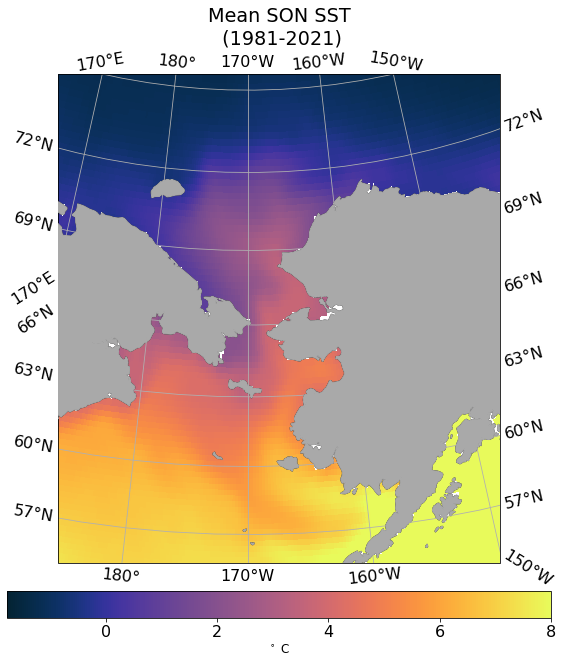

In [15]:
# Specify data projection
crs = ccrs.PlateCarree()
# Create a figure and axes using matplotlib
fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-170)})

# Specify the longitude and latitude, and the variable that you wish to plot
X = DS_sst['lon']
Y = DS_sst['lat']
Z = DS_sst['sst'].groupby('time.season').mean().sel(season='SON')

# Create a contour plot of SST
im = ax.pcolormesh(X,Y,Z,transform=crs,cmap='cmo.thermal',vmax=8)

# Zoom in around the Bering Strait
ax.set_extent([175, 210, 55, 75], crs=crs)
plt.title(f'Mean SON SST\n ({DS_sst.time.dt.year.values[0]}-{DS_sst.time.dt.year.values[-1]})')

# Finally, add a colorbar
cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('$^\circ$ C',fontsize=12)
# bx_lons = np.concatenate(([lons[0]], np.linspace(lons[0],lons[1],10),  np.linspace(lons[1],lons[0],10)))
# bx_lats = np.concatenate(([lats[0]], lats[1]*np.ones((10,), dtype=int),  lats[0]*np.ones((10,), dtype=int)))
# plt.plot(bx_lons,bx_lats,c='k',transform=crs,zorder=10)

# Add a land mask to your plot, as well as grid lines and coastlines
ax.add_feature(cfeature.LAND,zorder=9,facecolor='darkgray')
ax.gridlines(draw_labels=True,dms=True,x_inline=False,y_inline=False,
             crs=crs,xlocs=[170,180,-170,-160,-150])
ax.coastlines()
plt.show()

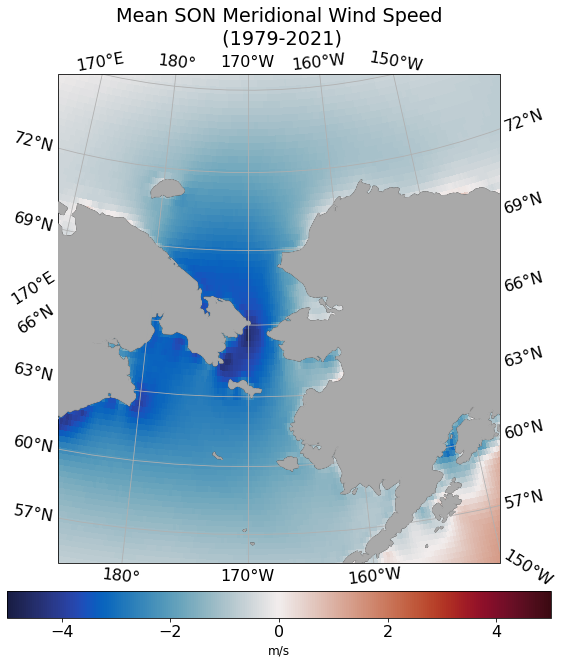

In [16]:
# Specify data projection
crs = ccrs.PlateCarree()
# Create a figure and axes using matplotlib
fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-170)})

# Specify the longitude and latitude, and the variable that you wish to plot
X = DS_v10['lon']
Y = DS_v10['lat']
Z = DS_v10['v10'].groupby('time.season').mean().sel(season='SON')

# Create a contour plot of SST
im = ax.pcolormesh(X,Y,Z,transform=crs,cmap='cmo.balance',vmin=-5, vmax=5)

# Zoom in around the Bering Strait
ax.set_extent([175, 210, 55, 75], crs=crs)
plt.title(f'Mean SON Meridional Wind Speed\n ({DS_v10.time.dt.year.values[0]}-{DS_v10.time.dt.year.values[-1]})')

# Finally, add a colorbar
cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('m/s',fontsize=12)
# bx_lons = np.concatenate(([lons[0]], np.linspace(lons[0],lons[1],10),  np.linspace(lons[1],lons[0],10)))
# bx_lats = np.concatenate(([lats[0]], lats[1]*np.ones((10,), dtype=int),  lats[0]*np.ones((10,), dtype=int)))
# plt.plot(bx_lons,bx_lats,c='k',transform=crs,zorder=10)

# Add a land mask to your plot, as well as grid lines and coastlines
ax.add_feature(cfeature.LAND,zorder=9,facecolor='darkgray')
ax.gridlines(draw_labels=True,dms=True,x_inline=False,y_inline=False,
             crs=crs,xlocs=[170,180,-170,-160,-150])
ax.coastlines()
plt.show()

## Set lat,lon for analysis

In [17]:
lats = np.array([50, 80])
lons = np.array([160, 230])

## Extract regions for analysis

In [18]:
# SST
sst = DS_sst.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))
# Mask land
sst['area'][:,:] = sst.area.where(sst['sst'].isel(time=0).notnull()).values

In [19]:
# Winds
# Mask land
DS_v10['area'][:,:] = DS_v10['area'] * (1 - DS_e5lm['lsm'])
# Extract
v10 = DS_v10.sel(lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))

## Calc area-mean, climatology, and anomaly

In [20]:
# SST
# mean
sst['bx_mean'] = ((sst['sst'] * sst.area).sum(['lat','lon']) / sst.area.sum(['lat','lon']))
# climatology
sst['clim'] = sst['bx_mean'].groupby("time.month").mean("time")
# anomaly
sst['anom'] = sst['bx_mean'].groupby("time.month") - sst['clim']

In [21]:
# Winds
# area mean
v10['bx_mean'] = ((v10['v10'] * v10.area).sum(['lat','lon']) / v10.area.sum(['lat','lon']))
# climatology
v10['clim'] = v10['bx_mean'].groupby("time.month").mean("time")
# anomaly
v10['anom'] = v10['bx_mean'].groupby("time.month") - v10['clim']

## Plot Fall anomalies for each field

In [22]:
t0 = v10.time.values[0]
tn = v10.time.values[-1]

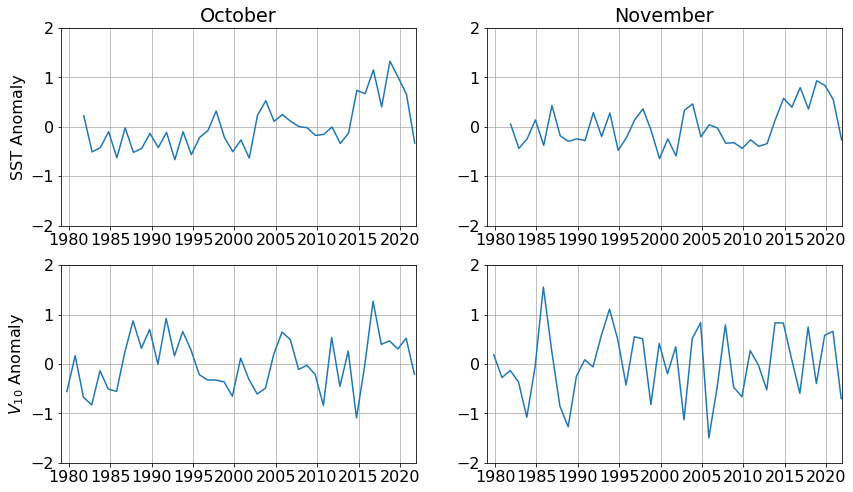

In [23]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(14,8))

# October
im = 10
# SST
x = sst['time'].sel(time=sst.time.dt.month.isin(im))
y = sst['anom'].sel(time=sst.time.dt.month.isin(im))
ax0.plot(x,y)
ax0.set_title('October')
ax0.set_ylabel('SST Anomaly')
ax0.set_ylim(-2,2)
ax0.set_xlim(t0,tn)
ax0.grid()

# Winds
x = v10['time'].sel(time=v10.time.dt.month.isin(im))
y = v10['anom'].sel(time=v10.time.dt.month.isin(im))
ax2.plot(x,y)
ax2.set_ylabel('$V_{10}$ Anomaly')
ax2.set_ylim(-2,2)
ax2.set_xlim(t0,tn)
ax2.grid()

# November
im = 11
# SST
x = sst['time'].sel(time=sst.time.dt.month.isin(im))
y = sst['anom'].sel(time=sst.time.dt.month.isin(im))
ax1.plot(x,y)
ax1.set_title('November')
ax1.set_ylim(-2,2)
ax1.set_xlim(t0,tn)
ax1.grid()

# Winds
x = v10['time'].sel(time=v10.time.dt.month.isin(im))
y = v10['anom'].sel(time=v10.time.dt.month.isin(im))
ax3.plot(x,y)
ax3.set_ylim(-2,2)
ax3.set_xlim(t0,tn)
ax3.grid()

plt.show()